In [1]:
from sklearn.metrics import mean_squared_error as MSE
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import os
from os import walk
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from datetime import datetime,timedelta
import talib as ta
from sklearn.preprocessing import MinMaxScaler
from math import floor
import sys
import pandas as pd
from tqdm import tqdm
import shutil
import random


In [2]:
def meanSE(yhat,ypred):
    return np.mean((ypred-yhat) ** 2)

In [3]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
companies = []
data_path = "Best/Graphs"
for (dirpath, dirnames, filenames) in walk(data_path):
    companies.extend(filenames)
    break 
print(len(companies))

503


In [5]:
def company(stock,startDate, endDate,startingCapital,plot = False, s = 1):
    model = "Best/Models/{}-model.json".format(stock)
    if not os.path.isfile("{}/saved_model.pb".format(model)):
        return 0,0,0,0,0
    start = startDate
    dataPath = "/Users/ishan/Coding/Wpi/StockMarketSimulationIQP/Datasets/30y_stock_csvs"
    dataTrain = pd.read_csv("{}/{}.csv".format(dataPath,stock)) #import csv
    dataTrain['Datetime']= pd.to_datetime(dataTrain['Datetime'])
    if startDate < dataTrain.iloc[0, :]['Datetime']:
        startDate = dataTrain.iloc[0, :]['Datetime']
    days = timedelta(93)
    startDate = startDate - days
    if startDate < dataTrain.iloc[0,:]['Datetime']:
        startDate = dataTrain.iloc[0,:]['Datetime']
    dataTrain = dataTrain[~(dataTrain['Datetime'] < startDate)]
    dataTrain = dataTrain[~(dataTrain['Datetime'] > endDate)]
    rsiPeriod = 14
    adxPeriod = 14
    shift = s
    leftshift = 33
    window = 60

    # %%
    variablesToInclude = ['Close','Volume',"RSI","ADX","fastd","fastk","macd"]
    numberOfFeatures = len(variablesToInclude)
    
    trainingDataPoints = round(len(dataTrain) * .4)
    
    dataTrain.rename(columns = {'CLOSE':'Close'}, inplace = True)
    dataTrain.rename(columns = {'HIGH':'High'}, inplace = True)
    dataTrain.rename(columns = {'LOW':'Low'}, inplace = True)
    dataTrain.rename(columns = {'VOLUME':'Volume'}, inplace = True)


    # %%

    dataTrain['Close'] = dataTrain['Close'].astype(float).fillna(0)
    data = dataTrain['Close']
    if len(dataTrain) == 0:
        return 0,0,0,0,0
    dataTrain["RSI"] = ta.RSI(dataTrain['Close'],rsiPeriod).fillna(0)
    dataTrain["ADX"] = ta.ADX(dataTrain['High'],dataTrain['Low'],dataTrain['Close'],adxPeriod).fillna(0)
    fastk, fastd = ta.STOCHF(dataTrain['High'],dataTrain['Low'],dataTrain['Close'])
    dataTrain['fastd'] = fastd
    dataTrain['fastk'] = fastk
    macd, macdsignal, macdhist = ta.MACD(dataTrain['Close'])
    dataTrain['macd'] = macd
    dataTrain['macdsignal'] = macdsignal
    dataTrain['macdhist'] = macdhist
    upper,middle,lower = ta.BBANDS(dataTrain['Close'])
    dataTrain['bb_lowerband'] = lower
    dataTrain['bb_middleband'] = middle
    dataTrain['bb_upperband'] = upper

    # %%
    newTrain = pd.DataFrame()
    newTrain = dataTrain[variablesToInclude]
    newTrain["Close"] = newTrain['Close'].shift(1)

    # %%

    trainingSet = newTrain.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN
    ySet = data.astype(float).values.reshape(-1, 1)

    # %% [markdown]
    # ## Feature Scaling

    # %%
    # Use normalization x - min(x) / max(min) - min(x)
    sc = MinMaxScaler(feature_range=(0,1)) # all values between 0 and 1
    ySC = MinMaxScaler(feature_range=(0,1))
    ySCSet = ySC.fit_transform(ySet)
    scaleTrainingSet = sc.fit_transform(trainingSet)


    
    regressor=tf.keras.models.load_model(model)
    dataTest = pd.read_csv("{}/{}.csv".format(dataPath,stock)) #import csv
    dataTest.rename(columns = {'CLOSE':'Close'}, inplace = True)
    dataTest.rename(columns = {'HIGH':'High'}, inplace = True)
    dataTest.rename(columns = {'LOW':'Low'}, inplace = True)
    dataTest.rename(columns = {'VOLUME':'Volume'}, inplace = True)

    # %%
    dataTest['Datetime']= pd.to_datetime(dataTest['Datetime'])
    if startDate < dataTrain.iloc[0,:]['Datetime']:
        startDate = dataTrain.iloc[0,:]['Datetime']
    dataTest = dataTest[~(dataTest['Datetime'] < startDate)]
    dataTest = dataTest[~(dataTest['Datetime'] > endDate)]
    dataTest['Close'] = dataTest['Close'].astype(float)
    dataTest["RSI"] = ta.RSI(dataTest['Close'],rsiPeriod)
    dataTest["ADX"] = ta.ADX(dataTest['High'],dataTest['Low'],dataTest['Close'],adxPeriod)
    fastk, fastd = ta.STOCHF(dataTest['High'],dataTest['Low'],dataTest['Close'])
    dataTest['fastd'] = fastd
    dataTest['fastk'] = fastk
    macd, macdsignal, macdhist = ta.MACD(dataTest['Close'])
    dataTest['macd'] = macd
    dataTest['macdsignal'] = macdsignal
    dataTest['macdhist'] = macdhist
    upper,middle,lower = ta.BBANDS(dataTest['Close'])
    dataTest['bb_lowerband'] = lower
    dataTest['bb_middleband'] = middle
    dataTest['bb_upperband'] = upper
    dataTest['Daily Returns'] = dataTest['Close'].pct_change(1)
    
    Sharpe_Ratio = dataTest['Daily Returns'].mean() / dataTest['Daily Returns'].std()
    tradingdays = (endDate-start).days
    sharperatio = (tradingdays ** 0.5) * Sharpe_Ratio
    negs = dataTest[dataTest['Daily Returns']<0]['Daily Returns']
    sortinoRatio = (dataTest['Daily Returns'].mean() / negs.std()) * (tradingdays ** 0.5)

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = dataTest['Daily Returns'].cummax()
    Daily_Drawdown = (dataTest['Daily Returns']/Roll_Max) - 1.0

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    calm = dataTest['Daily Returns'].mean()
    calmerRatio = (calm/Max_Daily_Drawdown) * (tradingdays ** 0.5)
    
    # %%
    newTest = pd.DataFrame()
    newTest = dataTest[variablesToInclude]
    
    # %%
    realStockPrice = dataTest['Close'].values #convert to numpy to train RNN
    newTest["Close"] = newTest['Close'].shift(1)
    trainingSet = newTest.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN

    inputs = trainingSet
    inputs = sc.transform(inputs)

    # %%
    xTest = []
    for i in range(window+leftshift, len(inputs)):
        xTest.append(inputs[i-window:i])
    xTest = np.array(xTest)
    # batchsize, inputSize, numberOfFeatures
    try:
        xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], numberOfFeatures))
    except:
        return 0,0,0,0,0


    # %%
    predictedPrice = regressor.predict(xTest)
    predictedPrice = ySC.inverse_transform(predictedPrice)
    predictedPrice = predictedPrice
    stocksOwned = {}
    startingValue = startingCapital
    liquidValue = startingValue
    dailyReturns = []
    sold = 0
    diffrence = (len(realStockPrice)) - (len(predictedPrice))
    realStockPrice = realStockPrice[diffrence-shift:]

    # %% [markdown]
    # ## Predict price

    # %%



    loss = pd.DataFrame(columns=['i', 'Price'])
    profit = pd.DataFrame(columns=['i', 'Price'])
    buy = pd.DataFrame(columns=['i', 'Price'])
    returnDaily = 0

    
    for i in range(len(predictedPrice)):
        if realStockPrice[i] < predictedPrice[i] and stock not in stocksOwned:
            stocksOwned[stock] = (realStockPrice[i], liquidValue/realStockPrice[i])
            liquidValue -= liquidValue/realStockPrice[i] * realStockPrice[i]
            buy.loc[len(buy)] = [i, realStockPrice[i]]
        elif stock in stocksOwned and stocksOwned[stock][0] < realStockPrice[i]:
            if stocksOwned[stock][1] * realStockPrice[i] > stocksOwned[stock][1] * stocksOwned[stock][0]:
                profit.loc[len(profit)] = [i, realStockPrice[i]]
            else:
                loss.loc[len(loss)] = [i, realStockPrice[i]]
            liquidValue += stocksOwned[stock][1] * realStockPrice[i]
            percentGain = (realStockPrice[i] - stocksOwned[stock][0]) / stocksOwned[stock][0]
            sold += 1
            returnDaily = percentGain
            stocksOwned.pop(stock)
        if stock in stocksOwned and i == len(predictedPrice) - 1:
            if stocksOwned[stock][1] * realStockPrice[i] > stocksOwned[stock][1] * stocksOwned[stock][0]:
                profit.loc[len(profit)] = [i, realStockPrice[i]]
            else:
                loss.loc[len(loss)] = [i, realStockPrice[i]]
            liquidValue += stocksOwned[stock][1] * realStockPrice[i]
            percentGain = (realStockPrice[i] - stocksOwned[stock][0]) / stocksOwned[stock][0]
            returnDaily = percentGain
            stocksOwned.pop(stock)
            sold += 1
        dailyReturns.append(returnDaily)
        
    if plot:
        plt.plot(realStockPrice, color='red', label="Real Stock Price")
        plt.plot(predictedPrice, color='blue', label="Predicted Stock Price")
        plt.scatter(buy['i'], buy['Price'], marker="o", label = 'Buy', s=50)
        plt.scatter(profit['i'], profit['Price'], marker="^",
                    color='green', label="Sell - Profit", s=50)
        plt.scatter(loss['i'], loss['Price'], marker="v",
                    color='red', label='Sell - Loss ', s=50)
        plt.title("{} Stock Price".format(stock))
        plt.xlabel('Time')
        plt.ylabel("Price")
        plt.legend()
        plt.savefig('graphs/{}.png'.format(stock))
        plt.figure()

    dailyReturns = pd.Series(dailyReturns,dtype='float')
    if len(dailyReturns) and dailyReturns.std():
        Sharpe_Ratio = dailyReturns.mean() / dailyReturns.std()
        tradingdays = (endDate-start).days
        sharperatio = (tradingdays ** 0.5) * Sharpe_Ratio
    else:
        sharperatio = 0
    negs = dailyReturns[dailyReturns<0]
    if len(negs) and negs.std():
        sortinoRatio = (dailyReturns.mean() / negs.std()) * (tradingdays ** 0.5)

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = dailyReturns.cummax()
    Daily_Drawdown = (dailyReturns/Roll_Max) - 1.0

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    calm = dailyReturns.mean()
    calmerRatio = (calm/Max_Daily_Drawdown) * (tradingdays ** 0.5)
    calmerRatio = 0
    

    profit = (liquidValue - startingValue)
    return profit,sharperatio,sortinoRatio,calmerRatio,sold


In [6]:
def eval(startDate="1982-3-12", endDate="2022-02-1",weighted = False, companies = companies, s = 1):
    startDate = datetime.strptime(str(startDate), "%Y-%m-%d")
    endDate = datetime.strptime(str(endDate), "%Y-%m-%d")
    startDateThreshold = datetime.strptime("1982-3-12", "%Y-%m-%d")
    spstart = startDate

    if startDateThreshold > startDate:
        spstart = startDateThreshold
    profit = 0

    with HiddenPrints():
        sp500 = yf.download('^GSPC',spstart,endDate)

    profitsp500percentage = ((sp500['Close'][-1] - sp500['Close'][0])/sp500['Close'][0])*100
    profitsp500 = (500_000) * (profitsp500percentage/100)

    profit = 0
    sharperatio = []
    sortinoRatio = []
    calmerRatio = []

    topStock = ""
    maxProfit = float('-inf')
    lowestStock = ""
    minProfit = float('inf')

    index = 0
    sold = 0
    value = 500_000
    check = 0
    for i in tqdm(companies):
        with HiddenPrints():
            index += 1
        

            if weighted:    
                weightC = weight[i]
                print("{}, {}".format(i,weightC))
                startingCapital = 500_000 * weightC
                check += startingCapital
                profitC, sharperatioC, sortinoRatioC, calmerRatioC,soldC = company(i, startDate, endDate, startingCapital, s = s)
                sharperatio *= weightC
                sortinoRatio *= weightC
                calmerRatio *= weightC

            else:
                i = i[:-4]
                print(i)
                profitC, sharperatioC, sortinoRatioC, calmerRatioC, soldC = company(
                    i, startDate, endDate,s = s)

            profit += profitC
            sharperatio.append(sharperatioC)
            sortinoRatio.append(sortinoRatioC)
            calmerRatio.append(calmerRatioC)
            sold += soldC
            if profitC < minProfit:
                minProfit = profitC
                lowestStock = i

            if profitC > maxProfit:
                maxProfit = profitC
                topStock = i
        
    sharperatio = pd.Series(sharperatio).dropna()
    sortinoRatio = pd.Series(sortinoRatio).dropna()
    
    profitPercentage = (profit/(value))*100
    profit = round(profit,2)
    profitPercentage = round(profitPercentage,2)
    profitsp500 = round(profitsp500,2)
    profitsp500percentage = round(profitsp500percentage,2)
    sharperatio = round((sharperatio.mean()),2)
    sortinoRatio = round((sortinoRatio.mean()),2)
    calmerRatio = 0
    minProfit = round(minProfit,2)
    maxProfit = round(maxProfit,2)

    if profitsp500 < profit:
        beat = True
    else:
        beat = False
        
    print(check)
    print("Start Date: {}".format(str(startDate.date)))
    print("End Date: {}".format(str(endDate.date)))
    print("Profit: ${}".format(profit))
    print("ROI: {}%".format(profitPercentage))
    print("Most Profitable Stock: {}".format(topStock))
    print("Profit for {}: ${}".format(topStock,maxProfit))
    print("Least Profitable Stock: {}".format(lowestStock))
    print("Profit for {}: ${}".format(lowestStock,minProfit))
    print("Profit S&P500: ${}".format(profitsp500))
    print("S&P500 ROI: {}%".format(profitsp500percentage))
    print("Sharpe Ratio: {}".format(sharperatio))
    print("Sortino Ratio: {}".format(sortinoRatio))
    print("Calmer Ratio: {}".format(calmerRatio))
    print("Traded {} Times".format(sold))
    return profit, beat


In [7]:
def normalize(value, sum, length):

    return (value / sum)


def negativeMSE(value, max):
    return (-1 * value)


In [8]:
weights = pd.read_csv("OutputWeights.csv")
df = weights[['Company','Weight']]
companiesWeighted = list(df['Company'])
weight = dict(df.values)
df.describe()

,Weight
count,59.000000
mean,0.016949
std,0.016663
min,0.000000
25%,0.004253
50%,0.013444
75%,0.023959
max,0.084705


In [12]:
eval(startDate='2021-01-01', endDate='2021-03-1', s=3, weighted=True, companies=companiesWeighted)

100%|██████████| 59/59 [03:27<00:00,  3.52s/it]

Start Date: <built-in method date of datetime.datetime object at 0x7fe40336ce10>
End Date: <built-in method date of datetime.datetime object at 0x7fe40336ca50>
Profit: $13238.68
ROI: 2.65%
Most Profitable Stock: UAL
Profit for UAL: $2073.5
Least Profitable Stock: POOL
Profit for POOL: $-169.14
Profit S&P500: $14929.81
S&P500 ROI: 2.99%
Sharpe Ratio: 3.68
Sortino Ratio: 1.85
Calmer Ratio: 0
Traded 57 Times


(13238.68, False)

In [19]:
eval(startDate='2018-10-01', endDate='2019-01-1',s=3, weighted=True, companies=companiesWeighted)

100%|██████████| 83/83 [05:14<00:00,  3.79s/it]

Start Date: <built-in method date of datetime.datetime object at 0x7f79f7ba0f60>
End Date: <built-in method date of datetime.datetime object at 0x7f79f7ba02d0>
Profit: $-16828.22
ROI: -3.37%
Most Profitable Stock: WYNN
Profit for WYNN: $2834.44
Least Profitable Stock: MPC
Profit for MPC: $-4368.97
Profit S&P500: $-71418.55
S&P500 ROI: -14.28%
Sharpe Ratio: 4.31
Sortino Ratio: 0.05
Calmer Ratio: 0
Traded 287 Times


(-16828.22, True)

In [118]:
eval(startDate='2021-03-01', endDate='2021-05-1',
     s=3, weighted=True, companies=companiesWeighted)


Start Date: <built-in method date of datetime.datetime object at 0x7feee6d44720>
End Date: <built-in method date of datetime.datetime object at 0x7feee6d447e0>
Profit: $2388.95
ROI: 0.48%
Most Profitable Stock: RF
Profit for RF: $1395.23
Least Profitable Stock: IVZ
Profit for IVZ: $0.0
Profit S&P500: $35797.38
S&P500 ROI: 7.16%
Sharpe Ratio: 2.77
Sortino Ratio: 1.91
Calmer Ratio: 0
Traded 17 Times


(2388.95, False)

In [119]:
eval(startDate='2021-05-01', endDate='2021-07-1',
     s=3, weighted=True, companies=companiesWeighted)


Start Date: <built-in method date of datetime.datetime object at 0x7feee7cf00c0>
End Date: <built-in method date of datetime.datetime object at 0x7feee7cf0ae0>
Profit: $-25386.48
ROI: -5.08%
Most Profitable Stock: HPQ
Profit for HPQ: $60.06
Least Profitable Stock: HPE
Profit for HPE: $-5304.0
Profit S&P500: $12502.78
S&P500 ROI: 2.5%
Sharpe Ratio: -1.66
Sortino Ratio: 0.9
Calmer Ratio: 0
Traded 12 Times


(-25386.48, False)

In [120]:
eval(startDate='2021-06-01', endDate='2021-08-1',
     s=3, weighted=True, companies=companiesWeighted)


Start Date: <built-in method date of datetime.datetime object at 0x7feeea9c6720>
End Date: <built-in method date of datetime.datetime object at 0x7feeea9c6b10>
Profit: $2078.04
ROI: 0.42%
Most Profitable Stock: HPE
Profit for HPE: $3177.04
Least Profitable Stock: KMI
Profit for KMI: $-2597.24
Profit S&P500: $22991.18
S&P500 ROI: 4.6%
Sharpe Ratio: 4.36
Sortino Ratio: 1.26
Calmer Ratio: 0
Traded 30 Times


(2078.04, False)

In [121]:

eval(startDate='2021-07-01', endDate='2021-09-1',
     s=3, weighted=True, companies=companiesWeighted)


Start Date: <built-in method date of datetime.datetime object at 0x7feee604d510>
End Date: <built-in method date of datetime.datetime object at 0x7feee604d900>
Profit: $-1172.84
ROI: -0.23%
Most Profitable Stock: AMCR
Profit for AMCR: $3422.06
Least Profitable Stock: NWS
Profit for NWS: $-3524.09
Profit S&P500: $23465.63
S&P500 ROI: 4.69%
Sharpe Ratio: 4.79
Sortino Ratio: 0.46
Calmer Ratio: 0
Traded 28 Times


(-1172.84, False)

In [12]:

eval(startDate='2021-11-01', endDate='2022-01-1',
     s=3, weighted=True, companies=companiesWeighted)


100%|██████████| 59/59 [03:24<00:00,  3.47s/it]

499999.99999999854
Start Date: <built-in method date of datetime.datetime object at 0x7f91c4922ba0>
End Date: <built-in method date of datetime.datetime object at 0x7f91c49223f0>
Profit: $13721.19
ROI: 2.74%
Most Profitable Stock: NXPI
Profit for NXPI: $3220.83
Least Profitable Stock: CRM
Profit for CRM: $-535.66
Profit S&P500: $16528.08
S&P500 ROI: 3.31%
Sharpe Ratio: 5.66
Sortino Ratio: 0.49
Calmer Ratio: 0
Traded 109 Times


(13721.19, False)

0

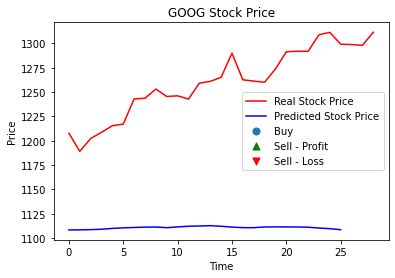

<Figure size 432x288 with 0 Axes>

In [10]:
startDate = datetime.strptime('2019-08-31', "%Y-%m-%d")
endDate = datetime.strptime('2019-11-15', "%Y-%m-%d")
profitC, sharperatioC, sortinoRatioC, calmerRatioC, soldC = company(
    'GOOG', startDate=startDate, endDate=endDate, plot=True, s=3,startingCapital=500)
profitC

In [11]:
eval(startDate='1982-03-01', endDate='2022-02-01',
     s=3, weighted=True, companies=companiesWeighted)

100%|██████████| 59/59 [05:18<00:00,  5.40s/it]

499999.99999999854
Start Date: <built-in method date of datetime.datetime object at 0x7f91cb2d3c30>
End Date: <built-in method date of datetime.datetime object at 0x7f91cb2d3720>
Profit: $1603260993794906.5
ROI: 320652198758.98%
Most Profitable Stock: DISH
Profit for DISH: $1594599928583054.8
Least Profitable Stock: SNA
Profit for SNA: $0.0
Profit S&P500: $20287909.86
S&P500 ROI: 4057.58%
Sharpe Ratio: 134.83
Sortino Ratio: 4.9
Calmer Ratio: 0
Traded 21883 Times


(1603260993794906.5, True)

In [9]:
totalWins = 0
with HiddenPrints():
    for i in tqdm(range(10)):
        start = datetime(2019,1,1)
        startDate = datetime(1981,1,1)
        while startDate < start:
            year = random.randint(0, 82)
            leapyear = False
            if (year % 400 == 0) and (year % 100 == 0) or ((year % 4 == 0) and (year % 100 != 0)):
                leapyear = True
            if year > 21:
                year = "19{}".format(year)
            else:
                if year < 10:
                    year = year = "200{}".format(year)
                else:
                    year = "20{}".format(year)
            month = str(random.randint(1,12))
            possibleDays = {'1':31, '2':28, '3': 31, '4': 30, '5':31, '6':30, '7':31, '8': 31, '9': 30, '10': 31, '11': 30, '12': 31}
            day = str(random.randint(1,possibleDays[month]))
            if leapyear and month is '2':
                day = str(random.randint(1, 29))
            
            startDate = '{}-{}-{}'.format(year, month, day)
            
            startDate = datetime.strptime(startDate, "%Y-%m-%d")
        
        days = timedelta(76)
        endDate = startDate + days
        startDate = str(startDate)[:10]
        endDate = str(endDate)[:10]
        _, win = eval(startDate = startDate, endDate = endDate, s = 3,weighted=True, companies=companiesWeighted)
        if win:
            totalWins += 1
print(totalWins)


 10%|█         | 1/10 [04:04<36:37, 244.12s/it]/Users/ishan/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/ishan/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/ishan/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/ishan/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
100%|██████████| 10/10 [38:24<00:00, 230.49s/it]

4
